In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Polygon
from matplotlib.lines import Line2D
from sklearn.utils import check_random_state
from scipy.optimize import fmin_l_bfgs_b
from scipy.stats import norm
import jax
import jax.numpy as jnp
from time import time
from multiviewica_delay import data_generation

# parameters

In [182]:
m = 10
p = 5
n = 600
max_shift = 30
max_dilation = 1.05
dilation_scale = 20.  # 200.
t0 = 0
noise_data = 0.01  # 0.02
noise_model = 1
random_state = 36755

# apply delay function

In [183]:
def apply_both_delays_2d_cyclic(
    S,
    a,
    b,
    max_shift=0.,
    max_dilation=1.,
    dilation_scale=1.,
    t0=0,
):
    p, n = S.shape
    max_delay = (np.ceil((n + max_shift) * max_dilation) - n).astype("int")
    S_extended = jnp.concatenate([S[:, n-max_delay:], S, S[:, :max_delay]], axis=1)
    t_extended = jnp.arange(n + 2 * max_delay) - max_delay - t0
    t = jnp.arange(n) - t0
    T = jnp.array([t] * p)
    T_ab = ((T.T - b) * a / dilation_scale).T
    S_ab = jnp.array(
        [jnp.interp(x=T_ab[i], xp=t_extended, fp=S_extended[i], left=0, right=0)
         for i in range(p)])
    return S_ab

def apply_both_delays_3d_cyclic(
    S_list,
    A,
    B,
    max_shift=0.,
    max_dilation=1.,
    dilation_scale=1.,
    t0=0,
):
    Y_list = jnp.array(
        [apply_both_delays_2d_cyclic(
            S_list[i], a=A[i], b=B[i], max_shift=max_shift, max_dilation=max_dilation, 
            dilation_scale=dilation_scale, t0=t0) 
         for i in range(len(S_list))])
    return Y_list

# generate data

In [184]:
# modification of the function data_generation
def sources_generation_zero_mean(p, n, rng=None):
    means = np.cumsum(rng.poisson(lam=n/(2*p), size=p)) + n // 6
    rng.shuffle(means)
    variances = rng.randint(n // 25, n // 8, size=p)
    heights = rng.randint(80, 120, size=p) / 100

    def f(x, mean, var):
        t = (x - mean) / var
        t[t > 0] /= 2
        s = -t/2 * np.exp(-t ** 2)
        s[s < 0] /= 2
        return s
    S = np.array(
        [height * f(np.arange(n), mean, var)
         for height, mean, var in zip(heights, means, variances)])
    return S

def data_generation(
    m,
    p,
    n,
    max_shift=0.,
    max_dilation=1.,
    noise_data=0.05,
    t0=0,
    rng=None,
):
    S = sources_generation_zero_mean(p, n, rng)
    S_list = np.array([S] * m) + noise_data * rng.randn(m, p, n)
    A_list = rng.randn(m, p, p)
    dilations = rng.uniform(low=1/max_dilation, high=max_dilation, size=(m, p))
    shifts = rng.uniform(low=-max_shift, high=max_shift, size=(m, p))
    S_list = apply_both_delays_3d_cyclic(
        S_list, A=dilations, B=shifts, max_shift=max_shift, max_dilation=max_dilation,
        dilation_scale=1., t0=t0)
    X_list = np.array([np.dot(A, S) for A, S in zip(A_list, S_list)])
    return X_list, A_list, dilations, shifts, S_list, S

In [185]:
# generate data
rng = check_random_state(random_state)
X_list, A_list, dilations, shifts, S_list, S = data_generation(
    m=m,
    p=p,
    n=n,
    max_shift=max_shift,
    max_dilation=max_dilation,
    noise_data=noise_data,
    t0=t0,
    rng=rng,
)

# plot data

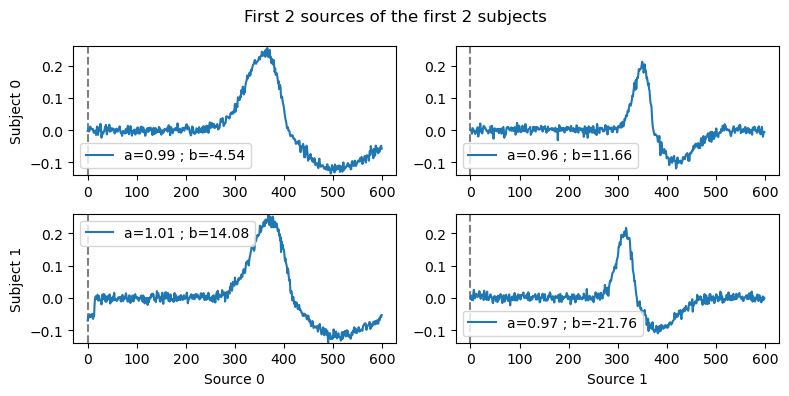

In [186]:
# plot 2 sources of 2 subjects
plt.subplots(2, 2, figsize=(8, 4))

for i in range(2):
    for j in range(2):
        plt.subplot(2, 2, 2 * i + j + 1)
        plt.plot(S_list[i, j], label=f'a={dilations[i, j]:.2f} ; b={shifts[i, j]:.2f}')
        plt.vlines(x=t0, ymin=np.min(S_list), ymax=np.max(S_list), linestyles='--', colors='grey')
        plt.ylim([np.min(S_list), np.max(S_list)])
        if j == 0:
            plt.ylabel(f"Subject {i}")
        if i == 1:
            plt.xlabel(f"Source {j}")
        plt.legend()
plt.suptitle(f"First 2 sources of the first 2 subjects")
plt.tight_layout()
plt.show()

# start by only estimating dilations and shifts

In [187]:
def loss_A_B_jax(A_B, S_list_1, S_list_2):
    A = A_B[:m*p].reshape((m, p))
    B = A_B[m*p:].reshape((m, p))
    S_list_2_delayed = apply_both_delays_3d_cyclic(
        S_list_2, A, B, max_shift=max_shift, max_dilation=max_dilation,
        dilation_scale=dilation_scale, t0=t0)
    return jnp.mean((S_list_1 - S_list_2_delayed) ** 2)

# grad = jax.grad(loss_A_B_jax)

In [8]:
# alpha = 8000.
# n_iter = 200
# A_B_init = jnp.concatenate([jnp.ones(m * p) * dilation_scale, jnp.zeros(m * p)])
# A_B = A_B_init.copy()
# memory = []
# for i in range(n_iter):
#     grad_A_B = grad(A_B, S_list, np.array([S] * m))
#     A_B -= alpha * grad_A_B
#     print(i, A_B)
#     memory.append(np.array(A_B))
# memory = np.array(memory)

In [ ]:
# A = A_B[:m*p].reshape((m, p)) / dilation_scale
# B = A_B[m*p:].reshape((m, p))

In [9]:
# # scatter plots
# plt.subplots(1, 2, figsize=(8, 4))

# plt.subplot(1, 2, 1)
# plt.scatter(shifts, B)
# plt.title("Shifts")
# plt.xlabel("True shifts")
# plt.ylabel("Estimated shifts")

# plt.subplot(1, 2, 2)
# plt.scatter(dilations, A)
# plt.title("Dilations")
# plt.xlabel("True dilations")
# plt.ylabel("Estimated dilations")

# plt.tight_layout()
# plt.show()

# topomap of the partial loss

In [188]:
@np.vectorize
def partial_loss_topomap(a, b):
    A = np.ones((m, p))
    B = np.zeros((m, p))
    A[0, 0] = a
    B[0, 0] = b
    S_list_delayed = apply_both_delays_3d_cyclic(
        S_list,
        A,
        B,
        max_shift=max_shift,
        max_dilation=max_dilation,
        dilation_scale=1.,
        t0=t0,
    )
    Y_avg = np.mean(S_list_delayed, axis=0)
    Y_avg_rep = np.array([Y_avg] * m)
    return jnp.mean((S_list_delayed - Y_avg_rep) ** 2)

In [189]:
# takes ~ 5 minutes 45 seconds
compute_map = False
if compute_map:
    nb_points_grid = 100
    a_grid = np.linspace(1/max_dilation, max_dilation, nb_points_grid, endpoint=False)
    b_grid = np.linspace(-max_shift, max_shift, nb_points_grid, endpoint=False)
    A_grid, B_grid = np.meshgrid(a_grid, b_grid)
    L = partial_loss_topomap(A_grid, B_grid)

In [190]:
if compute_map:
    fig, ax = plt.subplots(figsize=(6, 6))

    img = ax.imshow(L, origin='lower')
    plt.xlabel("Dilation parameter $a$")
    plt.ylabel("Shift parameter $b$")
    plt.title(f"Loss with respect to $a$ and $b$\n $a^\star={dilations[0, 0]:.3f}$ ; $b^\star={shifts[0, 0]:.3f}$")
    plt.colorbar(img)

    # minimum and starting point
    plt.plot(np.argmin(np.abs(a_grid - dilations[0, 0])), np.argmin(np.abs(b_grid - shifts[0, 0])), 'x', label='true delays')
    plt.plot(np.argmin(np.abs(a_grid - 1.)), nb_points_grid/2, 'x', label='starting point')

    # contours
    cset = plt.contour(L, np.linspace(np.min(L) + (np.max(L) - np.min(L)) / 10, np.max(L), 10), linewidths=2)

    # set ticks
    xticks = yticks = np.linspace(0, nb_points_grid, 5)
    xticklabels = np.round(np.linspace(1/max_dilation, max_dilation, 5), 2)
    yticklabels = np.linspace(-max_shift, max_shift, 5)
    ax.set(xticks=xticks, xticklabels=xticklabels, yticks=yticks, yticklabels=yticklabels)
    plt.legend()
    plt.show()

We observe that the true delays are far from the argmin of the loss. This is logical since the loss also depends on other subjects.

# GIF

In [13]:
# memory_0_0_a = memory[:, 0] / dilation_scale
# memory_0_0_b = memory[:, m * p]

In [14]:
# # map to [0, nb_points_grid] because of xytickslabels
# def map_a(a, nb_points_grid=100, a_min=1/max_dilation, a_max=max_dilation):
#     return (a - a_min) / (a_max - a_min) * nb_points_grid

# def map_b(b, nb_points_grid=100, b_min=-max_shift, b_max=max_shift):
#     return (b - b_min) / (b_max - b_min) * nb_points_grid

# new_a = map_a(memory_0_0_a, nb_points_grid=nb_points_grid, a_min=1/max_dilation, a_max=max_dilation)
# new_b = map_b(memory_0_0_b, nb_points_grid=nb_points_grid, b_min=-max_shift, b_max=max_shift)

# memory_mapped = np.vstack([new_a, new_b]).T

In [15]:
plot_gif = False
if plot_gif:
    # colors
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']

    # background figure
    fig, ax = plt.subplots()
    img = ax.imshow(L, origin='lower')
    plt.xlabel("Dilation parameter $a$")
    plt.ylabel("Shift parameter $b$")
    plt.title(f"Loss with respect to $a$ and $b$\n $a^\star={dilations[0, 0]:.3f}$ ; $b^\star={shifts[0, 0]:.3f}$")
    plt.colorbar(img)
    plt.plot(np.argmin(np.abs(a_grid - dilations[0, 0])), np.argmin(np.abs(b_grid - shifts[0, 0])), 'x', label='true delays')
    plt.plot(np.argmin(np.abs(a_grid - 1.)), nb_points_grid/2, 'x', label='starting point')
    cset = plt.contour(L, np.linspace(np.min(L) + (np.max(L) - np.min(L)) / 10, np.max(L), 10), linewidths=2)
    xticks = yticks = np.linspace(0, nb_points_grid, 5)
    xticklabels = np.round(np.linspace(1/max_dilation, max_dilation, 5), 2)
    yticklabels = np.linspace(-max_shift, max_shift, 5)
    ax.set(xticks=xticks, xticklabels=xticklabels, yticks=yticks, yticklabels=yticklabels)
    plt.legend()

    # Initialize the points to be animated
    line, = ax.plot([], [], 'x', color=colors[1], markersize=2)

    # Initialize the data for the line
    x_data, y_data = [], []

    # Animation function
    def update(i):
        # Update the position of the point in each frame
        a_b = memory_mapped[i]
        x_data.append(a_b[0])
        y_data.append(a_b[1])

        # Update the line with all previous points
        line.set_data(x_data, y_data)

        return line,

    # Set the number of frames
    num_frames = len(memory_0_0_a)

    # Create animation
    ani = FuncAnimation(fig, update, frames=num_frames, blit=True)

    # Save the animation as a GIF
    results_dir = "/storage/store2/work/aheurteb/mvicad/lbfgsb_results/gifs/"
    gif_name = f"randomstate{random_state}"
    ani.save(results_dir + gif_name + '.gif', writer='imagemagick', fps=25)

    # Show the plot (if needed)
    plt.show()

# LBFGSB on dilations and shifts

In [191]:
val_and_grad = jax.jit(jax.value_and_grad(loss_A_B_jax))

def wrapper_loss_and_grad(A_B, S_list_1, S_list_2):
    loss, grad = val_and_grad(A_B, S_list_1, S_list_2)
    return loss, np.array(grad)

In [192]:
jax.config.update('jax_enable_x64', True)

In [193]:
# jit
A_B_init = jnp.concatenate([jnp.ones(m * p) * dilation_scale, jnp.zeros(m * p)])
start = time()
wrapper_loss_and_grad(A_B_init, S_list, np.array([S] * m))
print(f"time : {time() - start}")

time : 23.043391227722168


In [194]:
# bounds
bounds_A = [(1/max_dilation*dilation_scale, max_dilation*dilation_scale)] * (m * p)
bounds_B = [(-max_shift, max_shift)] * (m * p)
bounds_A_B = jnp.array(bounds_A + bounds_B)

In [195]:
# LBFGSB
res_lbfgsb_A_B = fmin_l_bfgs_b(
    func=wrapper_loss_and_grad,
    x0=A_B_init,
    args=(S_list, np.array([S] * m)),
    bounds=bounds_A_B,
    disp=True,
    factr=0,
    pgtol=1e-10,
)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          100     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.82530D-04    |proj g|=  8.57289D-05

At iterate    1    f=  9.82482D-04    |proj g|=  8.57102D-05
  ys=-9.566E-10  -gs= 4.743E-08 BFGS update SKIPPED

At iterate    2    f=  7.41609D-04    |proj g|=  6.47941D-05

At iterate    3    f=  3.46191D-04    |proj g|=  1.87526D-05

At iterate    4    f=  3.06849D-04    |proj g|=  1.06506D-05

At iterate    5    f=  2.90925D-04    |proj g|=  1.65571D-05

At iterate    6    f=  2.85836D-04    |proj g|=  3.32116D-06

At iterate    7    f=  2.82689D-04    |proj g|=  9.42224D-06

At iterate    8    f=  2.80420D-04    |proj g|=  7.29880D-06

At iterate    9    f=  2.76968D-04    |proj g|=  1.28587D-05

At iterate   10    f=  2.67282D-04    |proj g|=  1.36411D-05

At iterate   11    f=  2.43619D-04    |proj g|=  2.47099D-05

At iterate   12    f=  2.01899D-04  


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


In [196]:
A_B_lbfgsb = res_lbfgsb_A_B[0]
A_lbfgsb_A_B = A_B_lbfgsb[:m*p].reshape((m, p)) / dilation_scale
B_lbfgsb_A_B = A_B_lbfgsb[m*p:].reshape((m, p))

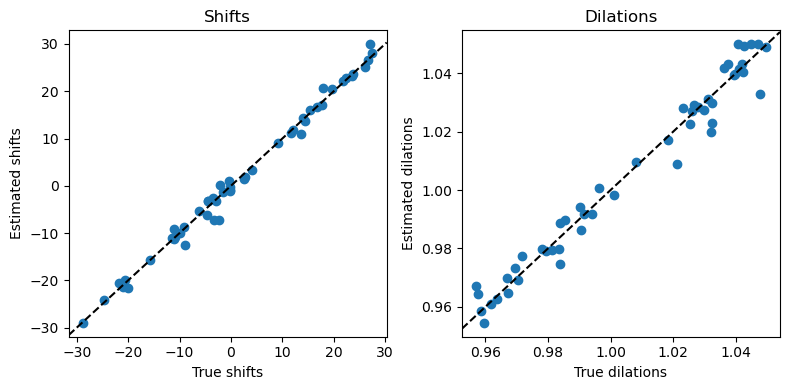

In [197]:
# scatter plots
plt.subplots(1, 2, figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.scatter(shifts, B_lbfgsb_A_B)
plt.title("Shifts")
plt.xlabel("True shifts")
plt.ylabel("Estimated shifts")
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
plt.plot([xmin, xmax], [xmin, xmax], c='k', linestyle='--')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

plt.subplot(1, 2, 2)
plt.scatter(dilations, A_lbfgsb_A_B)
plt.title("Dilations")
plt.xlabel("True dilations")
plt.ylabel("Estimated dilations")
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
plt.plot([xmin, xmax], [xmin, xmax], c='k', linestyle='--')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

plt.tight_layout()
plt.show()

In [154]:
# print(np.argmax(np.abs(dilations - A_lbfgsb_A_B)))
# print(np.argmax(np.abs(shifts - B_lbfgsb_A_B)))
# num = np.argmax(np.abs(shifts - B_lbfgsb_A_B))
# sub = num // p
# source = num % p

In [155]:
# plt.plot(S[source], label="original")
# plt.plot(
#     S_list[sub, source],
#     label=f"a={dilations[sub, source]:.3f} ; b={shifts[sub, source]:.3f}")
# plt.xlim([300, 500])
# plt.legend()
# plt.xlabel("Samples")
# plt.title(f"Worst estimated source : a={A_lbfgsb_A_B[sub, source]:.3f} ; b={B_lbfgsb_A_B[sub, source]:.3f}")
# plt.show()

# LBFSGB on unmixing matrices, dilations and shifts

Idea: maybe I could add a parameter shift_scale, as I did for dilation_scale. Because unmixing matrices and shifts shouldn't be optimized at the same speed.

In [23]:
# initialization parameters
W_list_true = np.array([np.linalg.inv(A) for A in A_list])
W_list_init = W_list_true + 0.2 * rng.randn(m, p, p)
# W_list_init = W_list_true + 0.01 * rng.randn(m, p, p)
dilations_init = jnp.ones((m, p)) * dilation_scale
shifts_init = jnp.zeros((m, p))
W_delays_init = jnp.concatenate(
    [jnp.ravel(W_list_init), jnp.ravel(dilations_init), jnp.ravel(shifts_init)])

In [33]:
# loss
def _logcosh(X):
    Y = jnp.abs(X)
    return Y + jnp.log1p(jnp.exp(-2 * Y))

def loss_W_A_B(W_list, dilations, shifts, X_list, noise_model=1, t0=0):
    _, p, _ = X_list.shape
    S_list = jnp.array([jnp.dot(W, X) for W, X in zip(W_list, X_list)])
    Y_list = apply_both_delays_3d_cyclic(S_list, A=1/dilations, B=-shifts, t0=t0)
    # Y_list = apply_both_delays_3d_cyclic(S_list, A=dilations, B=shifts, t0=t0)
    Y_avg = jnp.mean(Y_list, axis=0)
    loss = jnp.mean(_logcosh(Y_avg)) * p
    for W, Y in zip(W_list, Y_list):
        loss -= jnp.linalg.slogdet(W)[1]
        loss += 1 / (2 * noise_model) * jnp.mean((Y - Y_avg) ** 2) * p
    return loss

def vector_to_parameters(W_delays, m, p):
    W_list = W_delays[:m*p**2].reshape((m, p, p))
    dilations = W_delays[m*p**2: m*p*(p+1)].reshape((m, p))
    shifts = W_delays[m*p*(p+1):].reshape((m, p))
    return W_list, dilations, shifts

def wrapped_loss_W_A_B(W_delays, *args):
    return loss_W_A_B(*vector_to_parameters(W_delays, m, p), *args)

In [34]:
val_and_grad_W_A_B = jax.jit(jax.value_and_grad(wrapped_loss_W_A_B))

def wrapper_loss_and_grad_W_A_B(W_delays, X_list, noise_model, t0):
    loss, grad = val_and_grad_W_A_B(W_delays, X_list, noise_model, t0)
    return loss, np.array(grad)

In [35]:
# jit
start = time()
wrapper_loss_and_grad_W_A_B(W_delays_init, X_list, noise_model, t0)
print(f"time : {time() - start}")

time : 7.955358028411865


In [36]:
# bounds
bounds_W = [(-jnp.inf, jnp.inf)] * (m * p ** 2)
bounds_W_A_B = jnp.array(bounds_W + bounds_A + bounds_B)

In [37]:
# LBFGSB
res_lbfgsb_W_A_B = fmin_l_bfgs_b(
    func=wrapper_loss_and_grad_W_A_B,
    x0=W_delays_init,
    args=(X_list, noise_model, t0),
    bounds=bounds_W_A_B,
    disp=True,
    factr=0,
    pgtol=1e-9,
)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           40     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.91193D+00    |proj g|=  3.12472D+00

At iterate    1    f= -7.41730D+00    |proj g|=  8.57014D-01

At iterate    2    f= -9.08612D+00    |proj g|=  6.08251D-01

At iterate    3    f= -1.31386D+01    |proj g|=  3.55088D-01

At iterate    4    f= -1.68750D+01    |proj g|=  2.16283D-01

At iterate    5    f= -2.12416D+01    |proj g|=  1.31027D-01

At iterate    6    f= -2.55850D+01    |proj g|=  7.76525D-02

At iterate    7    f= -2.99861D+01    |proj g|=  4.52499D-02

At iterate    8    f= -3.41254D+01    |proj g|=  2.41347D-02

At iterate    9    f= -3.75219D+01    |proj g|=  3.66679D-02

At iterate   10    f= -3.97374D+01    |proj g|=  4.42887D-02

At iterate   11    f= -4.05224D+01    |proj g|=  2.13809D-02

At iterate   12    f= -4.05424D+01    |proj g|=  1.14482D-01

At iterate   13    f= -4.0


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


In [38]:
W_A_B_lbfgsb = res_lbfgsb_W_A_B[0]
W_lbfgsb = W_A_B_lbfgsb[:m*p**2].reshape((m, p, p))
A_lbfgsb = W_A_B_lbfgsb[m*p**2: m*p*(p+1)].reshape((m, p)) / dilation_scale
B_lbfgsb = W_A_B_lbfgsb[m*p*(p+1):].reshape((m, p))

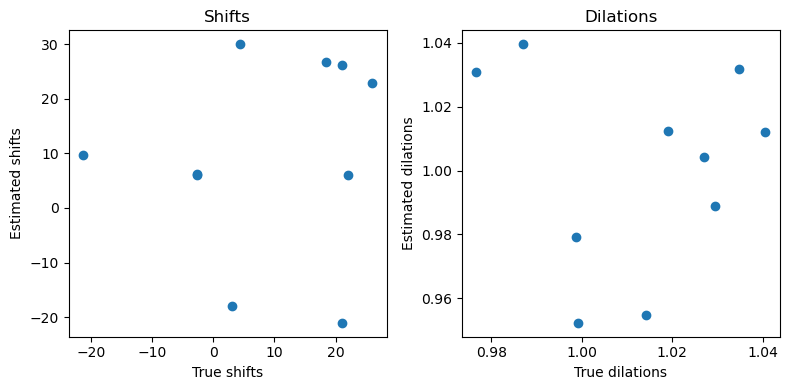

In [39]:
# scatter plots
plt.subplots(1, 2, figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.scatter(shifts, B_lbfgsb)
plt.title("Shifts")
plt.xlabel("True shifts")
plt.ylabel("Estimated shifts")

plt.subplot(1, 2, 2)
plt.scatter(dilations, A_lbfgsb)
plt.title("Dilations")
plt.xlabel("True dilations")
plt.ylabel("Estimated dilations")

plt.tight_layout()
plt.show()

We often obtain parameters equal to the bounds.

Maybe using shift_scale and increasing dilation_scale will solve this problem.

# histograms of unmixing matrices, dilations and shifts

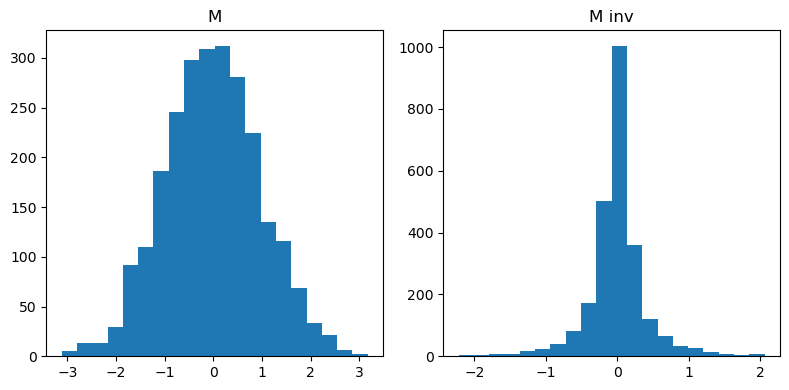

In [40]:
random_state = 0
rng = check_random_state(random_state)
matrix_size = 50
M = rng.randn(matrix_size, matrix_size)
M_inv = np.linalg.inv(M)

plt.subplots(1, 2, figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.hist(M.ravel(), bins=20)
plt.title("M")
plt.subplot(1, 2, 2)
plt.hist(M_inv.ravel(), bins=20)
plt.title("M inv")
plt.tight_layout()
plt.show()

Conclusion: W_list roughly belongs to [-1, 1], whereas shifts belong to [-max_shift, max_shift] and dilations belong to [1/max_dilation, max_dilation].